In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastcore.xtras import load_pickle

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_photoswitch_smiles_pred, evaluate_generated_smiles

from gptchem.settings import ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from guacamol.utils.chemistry import is_valid
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

import matplotx


%matplotlib inline

In [3]:
from rdkit import Chem

In [4]:
all_res = glob('out/**/*.pkl')

In [5]:
res = load_pickle(all_res[0])

In [6]:
from collections import defaultdict

In [7]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [8]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res['res_at_temp']:


        metrics= {
            'noise_level': res['noise_level'],
            'temp': temp_res['temperature'],
            'frac_valid': temp_res['frac_valid'],
            'frac_unique': temp_res['frac_unique'],
            'frac_smiles_in_train': temp_res['frac_smiles_in_train'],
            'frac_smiles_in_pubchem': temp_res['frac_smiles_in_pubchem'],
            'kld': temp_res['kld'],
            'frechet_d': temp_res['frechet_d'],
            'frechet_score': temp_res['frechet_score'],
            'frac_contains_azo': sum([contains_azo(s) for s in temp_res['valid_smiles']]) / len(temp_res['valid_smiles']),
        }

        generated_smiles.update([s for s in temp_res['generated_smiles'] if is_valid(s)])
        v_w_azo = [s for s in temp_res['generated_smiles'] if is_valid(s) and contains_azo(s)]
        generated_smiles_w_azos.update(v_w_azo)
        generated_smiles_w_azos_at_temp[temp_res['temperature']].update(v_w_azo)


        v = [s for s in temp_res['generated_smiles'] if is_valid(s)]
        generated_smiles_at_temp[temp_res['temperature']].update(v)

        for me, v in temp_res['e_pi_pi_star_metrics'].items():
            metrics["e_pi_pi_star_" + me] = v

        for me, v in temp_res['z_pi_pi_star_metrics'].items():
            metrics["z_pi_pi_star_" + me] = v
        compiled_res.append(metrics)

In [9]:
contains_azo(list(generated_smiles)[5])

True

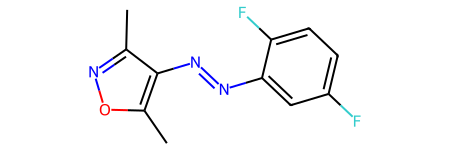

In [10]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [11]:
df = pd.DataFrame(compiled_res)

In [12]:
grouped = df.groupby(['temp']).agg(['mean', 'std'])

In [13]:
grouped

noise_level     frac_valid     frac_unique     frac_smiles_in_train      \
            mean std       mean std        mean std                 mean std   
temp                                                                           
0.00         0.5 NaN        1.0 NaN         0.6 NaN                  0.0 NaN   
0.10         0.5 NaN        1.0 NaN         0.6 NaN                  0.0 NaN   
0.20         0.5 NaN        1.0 NaN         0.8 NaN                  0.0 NaN   
0.50         0.5 NaN        1.0 NaN         1.0 NaN                  0.0 NaN   
0.75         0.5 NaN        1.0 NaN         0.8 NaN                  0.0 NaN   
1.00         0.5 NaN        0.6 NaN         1.0 NaN                  0.0 NaN   
1.25         0.5 NaN        0.2 NaN         1.0 NaN                  0.0 NaN   
1.50         0.5 NaN        0.2 NaN         1.0 NaN                  0.0 NaN   
2.00         0.5 NaN        0.2 NaN         1.0 NaN                  0.0 NaN   

     frac_smiles_in_pubchem      ... z_pi_pi_star_r2      \
                       mean std  ...            mean std   
temp                             ...                       
0.00                    1.0 NaN  ...       -0.125384 NaN   
0.10                    1.0 NaN  ...       -0.394620 NaN   
0.20                    1.0 NaN  ...       -0.145275 NaN   
0.50                    1.0 NaN  ...       -1.468414 NaN   
0.75                    1.0 NaN  ...       -1.179643 NaN   
1.00                    1.0 NaN  ...      -26.038951 NaN   
1.25                    1.0 NaN  ...             NaN NaN   
1.50                    1.0 NaN  ...             NaN NaN   
2.00                    1.0 NaN  ...             NaN NaN   

     z_pi_pi_star_max_error     z_pi_pi_star_mean_absolute_error      \
                       mean std                             mean std   
temp                                                                   
0.00              35.742127 NaN                        13.334744 NaN   
0.10              38.490332 NaN                        15.675723 NaN   
0.20              35.742127 NaN                        13.831574 NaN   
0.50              53.884617 NaN                        19.413660 NaN   
0.75              53.884617 NaN                        15.874802 NaN   
1.00              15.264796 NaN                        12.129880 NaN   
1.25               3.054375 NaN                         3.054375 NaN   
1.50               4.681312 NaN                         4.681312 NaN   
2.00              32.906224 NaN                        32.906224 NaN   

     z_pi_pi_star_mean_squared_error     z_pi_pi_star_rmse      
                                mean std              mean std  
temp                                                            
0.00                      322.508148 NaN         17.958512 NaN  
0.10                      399.664862 NaN         19.991620 NaN  
0.20                      328.208518 NaN         18.116526 NaN  
0.50                      707.388615 NaN         26.596778 NaN  
0.75                      624.633867 NaN         24.992676 NaN  
1.00                      166.178722 NaN         12.891033 NaN  
1.25                        9.329206 NaN          3.054375 NaN  
1.50                       21.914685 NaN          4.681312 NaN  
2.00                     1082.819599 NaN         32.906224 NaN  

[9 rows x 38 columns]

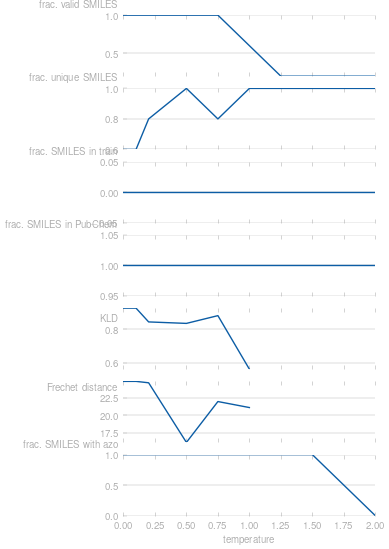

In [14]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(7,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, 2*ONE_COL_WIDTH_INCH))
    ax[0].plot(grouped.index, grouped['frac_valid']['mean'], label='frac_valid')
    ax[0].fill_between(grouped.index, grouped['frac_valid']['mean'] - grouped['frac_valid']['std'], grouped['frac_valid']['mean'] + grouped['frac_valid']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. valid SMILES', ax=ax[0])

    ax[1].plot(grouped.index, grouped['frac_unique']['mean'], label='frac_unique')
    ax[1].fill_between(grouped.index, grouped['frac_unique']['mean'] - grouped['frac_unique']['std'], grouped['frac_unique']['mean'] + grouped['frac_unique']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. unique SMILES', ax=ax[1])

    ax[2].plot(grouped.index, grouped['frac_smiles_in_train']['mean'], label='frac_smiles_in_train')
    ax[2].fill_between(grouped.index, grouped['frac_smiles_in_train']['mean'] - grouped['frac_smiles_in_train']['std'], grouped['frac_smiles_in_train']['mean'] + grouped['frac_smiles_in_train']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES in train', ax=ax[2])

    ax[3].plot(grouped.index, grouped['frac_smiles_in_pubchem']['mean'], label='frac_smiles_in_pubchem')
    ax[3].fill_between(grouped.index, grouped['frac_smiles_in_pubchem']['mean'] - grouped['frac_smiles_in_pubchem']['std'], grouped['frac_smiles_in_pubchem']['mean'] + grouped['frac_smiles_in_pubchem']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES in PubChem', ax=ax[3])

    ax[4].plot(grouped.index, grouped['kld']['mean'], label='kld')
    ax[4].fill_between(grouped.index, grouped['kld']['mean'] - grouped['kld']['std'], grouped['kld']['mean'] + grouped['kld']['std'], alpha=0.2)

    matplotx.ylabel_top('KLD', ax=ax[4])

    ax[5].plot(grouped.index, grouped['frechet_d']['mean'], label='frechet_d')
    ax[5].fill_between(grouped.index, grouped['frechet_d']['mean'] - grouped['frechet_d']['std'], grouped['frechet_d']['mean'] + grouped['frechet_d']['std'], alpha=0.2)

    matplotx.ylabel_top('Frechet distance', ax=ax[5])

    ax[6].plot(grouped.index, grouped['frac_contains_azo']['mean'], label='frechet_score')
    ax[6].fill_between(grouped.index, grouped['frac_contains_azo']['mean'] - grouped['frac_contains_azo']['std'], grouped['frac_contains_azo']['mean'] + grouped['frac_contains_azo']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES with azo', ax=ax[6])

    ax[-1].set_xlabel('temperature', labelpad=4)

    fig.savefig('photoswitch_extrapolation_smiles_metrics.pdf', bbox_inches='tight')

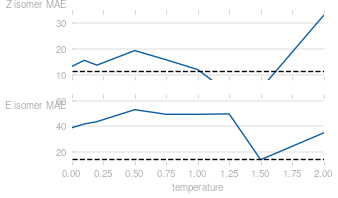

In [15]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(2,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

    ax[0].plot(grouped.index, grouped['z_pi_pi_star_mean_absolute_error']['mean'], label='e_pi_pi_star_metrics')
    ax[0].fill_between(grouped.index, grouped['z_pi_pi_star_mean_absolute_error']['mean'] - grouped['z_pi_pi_star_mean_absolute_error']['std'], grouped['z_pi_pi_star_mean_absolute_error']['mean'] + grouped['z_pi_pi_star_mean_absolute_error']['std'], alpha=0.2)

    matplotx.ylabel_top('Z isomer MAE', ax=ax[0])

    ax[0].hlines(11.616605626696359, 0, 2, color='k', linestyle='--')

    ax[0].set_ylim(8,35)

    ax[1].plot(grouped.index, grouped['e_pi_pi_star_mean_absolute_error']['mean'], label='e_pi_pi_star_metrics')
    ax[1].fill_between(grouped.index, grouped['e_pi_pi_star_mean_absolute_error']['mean'] - grouped['e_pi_pi_star_mean_absolute_error']['std'], grouped['e_pi_pi_star_mean_absolute_error']['mean'] + grouped['e_pi_pi_star_mean_absolute_error']['std'], alpha=0.2)

    matplotx.ylabel_top('E isomer MAE', ax=ax[1])

    ax[1].hlines(14.38998132190228, 0, 2, color='k', linestyle='--')

    ax[-1].set_xlabel('temperature', labelpad=4)
    ax[1].set_ylim(10,65)
fig.savefig('extrapolation_photoswitch_constrain_matches.pdf', bbox_inches='tight')

## Visualize

In [16]:
import tmap as tm
import numpy as np

from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem

from tqdm import tqdm

In [17]:
import os
import shutil

In [18]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data['SMILES'].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
    clear_color="#FFFFFF",
    coords=False,
    view="free",
    impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader='sphere',
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [19]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 403/403 [00:04<00:00, 92.28it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 403/403 [00:04<00:00, 100.67it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 404/404 [00:04<00:00, 98.31it/s] 


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 405/405 [00:04<00:00, 87.65it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 404/404 [00:05<00:00, 76.08it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 405/405 [00:04<00:00, 86.38it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 404/404 [00:04<00:00, 82.22it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 404/404 [00:05<00:00, 72.59it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 404/404 [00:04<00:00, 81.67it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

## Plot histograms

In [20]:
data = get_photoswitch_data()

In [21]:
data_subset = data.dropna(
        subset=["E isomer pi-pi* wavelength in nm", "SMILES", "Z isomer pi-pi* wavelength in nm"]
    )

In [22]:
data_tresholded = data_subset[data_subset['E isomer pi-pi* wavelength in nm'] < 350]

In [23]:
all_data = pd.concat([data_subset, data_tresholded])
all_data['kind'] = ['all'] * len(data_subset) + ['tresholded'] * len(data_tresholded)

In [24]:
from gptchem.evaluator import predict_photoswitch

In [25]:
predictions = []

for smile in generated_smiles:
    pred_e_pi_pi_star, pred_z_pi_pi_star = predict_photoswitch(smile)
    predictions.append(
        {
            'SMILES': smile,
            'E isomer pi-pi* wavelength in nm': pred_e_pi_pi_star[0][0],
            'Z isomer pi-pi* wavelength in nm': pred_z_pi_pi_star[0][0],
            "kind": "generated"
        }
    )

In [26]:
pred_frame =pd.DataFrame(predictions).drop_duplicates(subset=['SMILES'])

In [27]:
all_data = pd.concat([all_data, pred_frame])

In [28]:
all_data

,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,Z isomer pi-pi* wavelength in nm,...,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm,name,selfies,wavelength_cat,inchi,kind
0,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.000000,1.67,442.0,0.0373,290.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][N][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C10H10N4/c1-14-8-7-10(13-14)12-11-9-5...,all
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.000000,1.87,438.0,0.0505,272.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C9H9N5/c1-14-7-10-9(13-14)12-11-8-5-3...,all
2,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.000000,1.74,428.0,0.0612,286.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][C][C][C][=Branch1][Ri...,very small,InChI=1S/C11H12N4/c1-9-8-15(2)14-11(9)13-12-10...,all
3,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.000000,1.66,417.0,0.0640,275.000000,...,401.0,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][Branch1][C][=N][Ring1...,very small,InChI=1S/C10H10N4/c1-14-8-10(7-11-14)13-12-9-5...,all
4,C[N]1N=C(C)C(=C1C)N=NC2=CC=CC=C2,7.700000e-07,MeCN,98.0,98.0,335.000000,2.27,425.0,0.0963,296.000000,...,449.0,NaN,NaN,NaN,NaN,"phenyl-(1,3,5-trimethylpyrazol-4-yl)diazene",[C][NH0][N][=C][Branch1][C][C][C][=Branch1][Br...,very small,InChI=1S/C12H14N4/c1-9-12(10(2)16(3)15-9)14-13...,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,CC1=C(/N=N/C2=CC=CC=C2C)C(C)=NO1,NaN,NaN,NaN,NaN,315.786151,NaN,NaN,NaN,305.287686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
12,CN daughters Choose flavour 193 Cameroon Coral...,NaN,NaN,NaN,NaN,404.429453,NaN,NaN,NaN,322.929113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
13,CC1=NOC(C)=C1/N=N/C2=CC=C(C)C=C2,NaN,NaN,NaN,NaN,317.428861,NaN,NaN,NaN,304.485348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
14,FC1=CC=CC=C1/N=N/C2=C(F)C=CC=C2,NaN,NaN,NaN,NaN,326.858714,NaN,NaN,NaN,278.865923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated


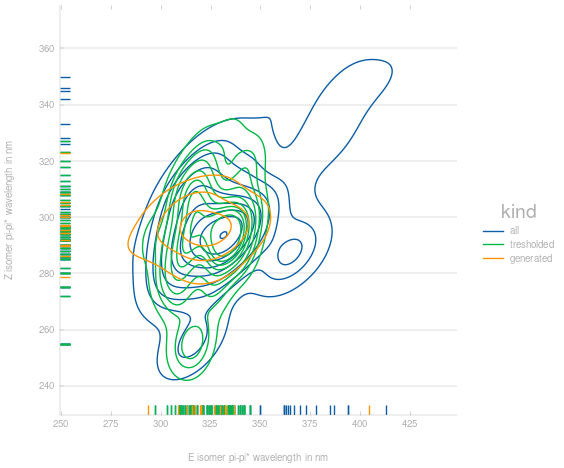

In [29]:
with plt.style.context(matplotx.styles.dufte):
    sns.displot(
        all_data,
        x = 'E isomer pi-pi* wavelength in nm',
        y = 'Z isomer pi-pi* wavelength in nm',
        kind='kde',
        hue='kind',
        rug=True,
    )

plt.savefig('extrapolation_photoswitch_dist.pdf', bbox_inches='tight')
